In [64]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

In [4]:
vix = pd.read_csv('vix_prices.csv')
prime = pd.read_csv('historic_prime_rates.csv')

In [6]:
vix['date'] = pd.to_datetime(vix['date'])
vix.vix_close.replace(np.nan,vix.vix_close.mean(),inplace=True)
vix.vix_close.isna().sum()

In [53]:
vix_close = vix.loc[:,['date','vix_close']]
vix_close.set_index('date',inplace=True)

In [55]:
model = ARIMA(vix_close, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a n

                             ARIMA Model Results                              
Dep. Variable:            D.vix_close   No. Observations:                 7316
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13439.599
Method:                       css-mle   S.D. of innovations              1.519
Date:                Wed, 16 Jan 2019   AIC                          26893.198
Time:                        16:14:25   BIC                          26941.483
Sample:                             1   HQIC                         26909.800
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.257e-05      0.013      0.004      0.997      -0.025       0.025
ar.L1.D.vix_close    -0.1143      0.012     -9.783      0.000      -0.137      -0.091
ar.L2.D.vix_close    -0.

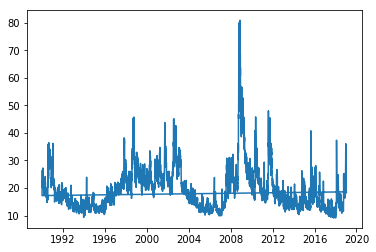

In [60]:
plt.plot(vix_close.index,vix_close.vix_close)

In [63]:
monthly_vix = vix_close.resample('M').mean()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


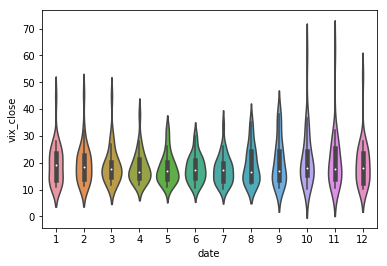

In [65]:
sns.violinplot(x=monthly_vix.index.month, y=monthly_vix.vix_close)


In [66]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

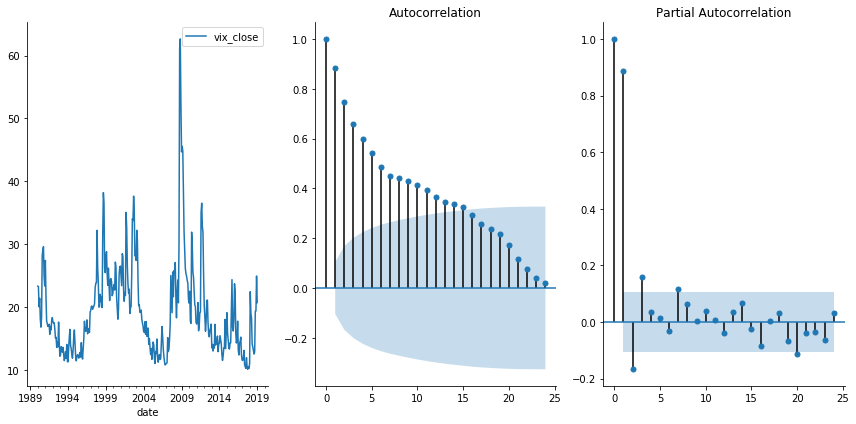

In [67]:
plots(monthly_vix, lags=24);


In [73]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          vix_close   No. Observations:                  349
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1022.475
Date:                            Thu, 17 Jan 2019   AIC                           2050.949
Time:                                    08:55:08   BIC                           2062.401
Sample:                                01-31-1990   HQIC                          2055.514
                                     - 01-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.278      0.041      0.967      -0.534       0.557
ar.L1          0.1081      0.048      2.266      0.023       0.015       0.202
sigma2        25.7451      1.092     23.584      0.000      23.606      27.885
===================================================================================
Ljung-Box (Q):                      185.52   Jarque-Bera (JB):              1275.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

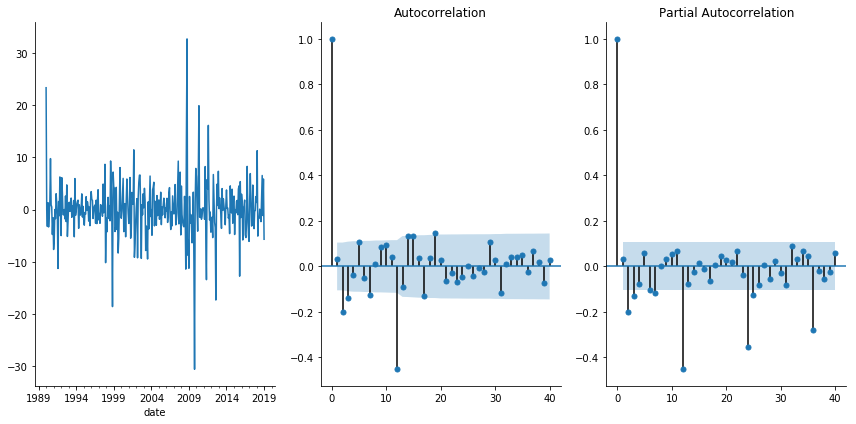

In [74]:
plots(sar.resid, lags=40);

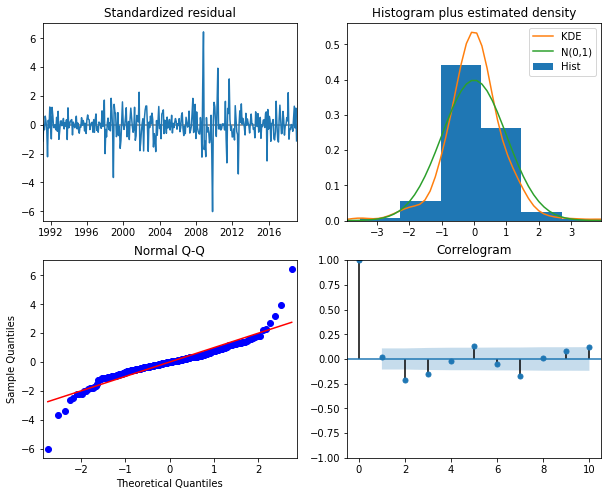

In [75]:
sar.plot_diagnostics(figsize=(10, 8));

In [76]:
monthly_vix.shape

(349, 1)

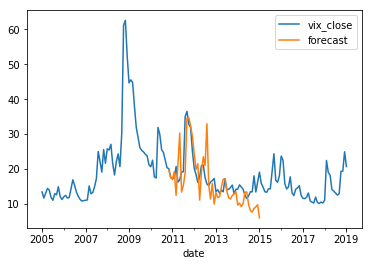

In [82]:
# plot predictions
monthly_vix['forecast'] = sar.predict(start = 250, end= 300, dynamic=30)  
monthly_vix[180:][['vix_close', 'forecast']].plot();

# per the documentation, we start predicting at period 750, and start a dynamic forecast at 750 + 30
# this means we use our predictions as "ground truth" for following predictions

## Look for stationarity of my data with Dicker Fuller test

In [86]:
import statsmodels.tsa.stattools as ts


In [87]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic           -4.307774
p-value                   0.000431
Lags Used                 2.000000
Observations Used       346.000000
Critical Value (1%)      -3.449392
Critical Value (5%)      -2.869930
Critical Value (10%)     -2.571240
dtype: float64


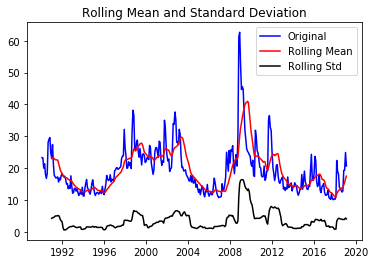

In [88]:
dftest(monthly_vix.vix_close)

It passed! According to Jonathan I can still try differencing.

## Now let's try an AR models

In [98]:
aic_res = []
for i in range(1,60):
    model = ARIMA(vix_close, order=(i,0,0))
    model_fit = model.fit()
    aic_res.append(model_fit.aic)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

KeyboardInterrupt: 

(array([9., 3., 3., 0., 2., 0., 0., 1., 0., 1.]),
 array([26804.84334591, 26824.93431462, 26845.02528333, 26865.11625203,
        26885.20722074, 26905.29818945, 26925.38915816, 26945.48012687,
        26965.57109557, 26985.66206428, 27005.75303299]),
 <a list of 10 Patch objects>)

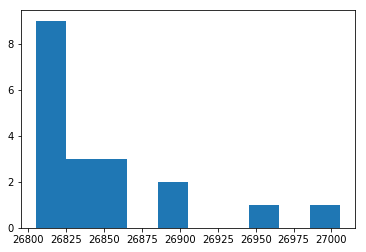

In [107]:
#aic_res
plt.hist(aic_res)

In [112]:
np_aic_res = np.array(aic_res)
print (np_aic_res.min(),np_aic_res.argmin())

26804.84334590905 11


In [111]:
np_aic_res[11]

array([27005.75303299, 26951.54485177, 26902.93891417, 26893.71379629,
       26864.21007756, 26863.0260661 , 26858.33916797, 26828.96835847,
       26825.67290188, 26826.7004739 , 26806.62950074, 26804.84334591,
       26806.30329134, 26806.45758674, 26808.25918726, 26808.20208952,
       26809.5270566 , 26808.8895997 , 26807.30894708])

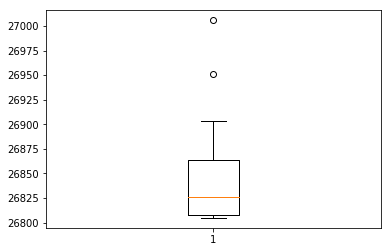

In [116]:
plt.boxplot(np_aic_res);

Best AIC for AR is 26804.84334590905 at p=12

In [118]:
model = ARIMA(vix_close, order=(12,0,0))
model_fit = model.fit()
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

                              ARMA Model Results                              
Dep. Variable:              vix_close   No. Observations:                 7317
Model:                    ARMA(12, 0)   Log Likelihood              -13388.422
Method:                       css-mle   S.D. of innovations              1.508
Date:                Thu, 17 Jan 2019   AIC                          26804.843
Time:                        15:47:47   BIC                          26901.415
Sample:                             0   HQIC                         26838.046
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               19.2360      1.332     14.444      0.000      16.626      21.846
ar.L1.vix_close      0.8774      0.012     75.079      0.000       0.855       0.900
ar.L2.vix_close      0.0087 

In [119]:
vix_close.isnull().any()

vix_close    False
dtype: bool

I'm getting a weird error but don't see any empty values.

" ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)" 

## Now let's try an AR models with differencing (ARI?)

In [160]:
model = ARIMA(vix_close, order=(12,2,0))
model_fit = model.fit()
model_fit.aic

TypeError: can only concatenate str (not "list") to str

With d = 2 it get better witih an AIC of 27536.5015262264

## Now let's try an ARIMA model

In [125]:
#I'm making p smaller to decrease compute time
aic_res_arima = []
for i in range(1,5):
    model = ARIMA(vix_close, order=(5,0,i))
    model_fit = model.fit()
    #print(i, model_fit.aic)
    aic_res_arima.append(model_fit.aic)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [126]:
aic_res_arima

[26841.557238232912,
 26842.207926725845,
 26829.541146411433,
 26826.830564932505]

Higher Q values help for a better score. But I set d back to 0 due to an error, will it work with a 2?

In [138]:
model = ARIMA(vix_close, order=(5,2,0))
model_fit = model.fit()
model_fit.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a n

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.vix_close   No. Observations:                 7315
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -14191.522
Method:                       css-mle   S.D. of innovations              1.684
Date:                Thu, 17 Jan 2019   AIC                          28397.045
Time:                        16:24:29   BIC                          28445.328
Sample:                             2   HQIC                         28413.646
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.822e-05      0.005      0.019      0.985      -0.010       0.010
ar.L1.D2.vix_close    -0.8932      0.011    -77.762      0.000      -0.916      -0.871
ar.L2.D2.vix_close    -0.7577      0.015    -51.156      0.000      -0.787      -0.729
ar.L3.D2.vix_close    -0.5678      0.016    -35.644      0.000      -0.599      -0.537
ar.L4.D2.vix_close    -0.3979      0.015    -26.861      0.000      -0.427      -0.369
ar.L5.D2.vix_close    -0.1866      0.011    -16.246      0.000      -0.209      -0.164
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5063           -1.2269j            1.3273           -0.1877
AR.2            0.5063           +1.2269j            1.3273            0.1877
AR.3           -0.8101           -1.1572j            1.4126           -0.3472
AR.4           -0.8101           +1.1572j            1.4126            0.3472
AR.5           -1.5244           -0.0000j            1.5244           -0.5000
-----------------------------------------------------------------------------
"""

Seems like my best model is (p,d,q) = (5,2,0) so far.

## SARIMA test

In [132]:
import statsmodels.api as sm

In [137]:
sar = sm.tsa.statespace.SARIMAX(vix_close, order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()
sar.aic

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


28397.04464448893

SARIMA isn't doing as well on AIC at 28397.04464448893

In [143]:
model = ARIMA(vix_close, order=(5,2,1))
model_fit = model.fit()
model_fit.aic

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


26902.058617698473

In [151]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_vix.vix_close, order=(5,2,0), seasonal_order=(5,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          vix_close   No. Observations:                  349
Model:             SARIMAX(5, 2, 0)x(5, 1, 0, 12)   Log Likelihood                -958.743
Date:                            Thu, 17 Jan 2019   AIC                           1941.486
Time:                                    17:35:53   BIC                           1987.255
Sample:                                01-31-1990   HQIC                          1959.733
                                     - 01-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0032      0.268     -0.012      0.990      -0.529       0.522
ar.L1         -0.6563      0.043    -15.315      0.000      -0.740      -0.572
ar.L2         -0.6838      0.047    -14.455      0.000      -0.777      -0.591
ar.L3         -0.4939      0.060     -8.269      0.000      -0.611      -0.377
ar.L4         -0.3215      0.053     -6.104      0.000      -0.425      -0.218
ar.L5         -0.0897      0.061     -1.462      0.144      -0.210       0.031
ar.S.L12      -0.8178      0.061    -13.307      0.000      -0.938      -0.697
ar.S.L24      -0.7548      0.081     -9.359      0.000      -0.913      -0.597
ar.S.L36      -0.5860      0.082     -7.134      0.000      -0.747      -0.425
ar.S.L48      -0.3099      0.080     -3.892      0.000      -0.466      -0.154
ar.S.L60      -0.2055      0.055     -3.743      0.000      -0.313      -0.098
sigma2        17.1167      0.909     18.821      0.000      15.334      18.899
===================================================================================
Ljung-Box (Q):                       61.56   Jarque-Bera (JB):               834.39
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Decent model, let's get predictions and MMSE

In [147]:
pred = sar.get_prediction(10,20)

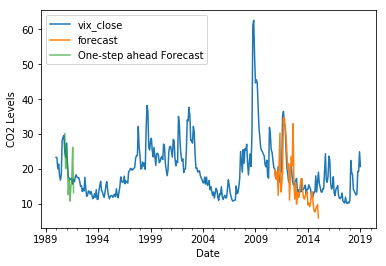

In [149]:
ax = monthly_vix.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()
pred.predicted_mean.plot

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)


## Retrain splitting train & test data

In [161]:
train,test = monthly_vix.iloc[:279,:],monthly_vix.iloc[279:,:]

In [162]:
sar = sm.tsa.statespace.SARIMAX(train.vix_close, order=(5,2,0), seasonal_order=(5,1,0,12), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          vix_close   No. Observations:                  279
Model:             SARIMAX(5, 2, 0)x(5, 1, 0, 12)   Log Likelihood                -766.356
Date:                            Thu, 17 Jan 2019   AIC                           1556.713
Time:                                    17:40:20   BIC                           1599.670
Sample:                                01-31-1990   HQIC                          1573.972
                                     - 03-31-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0106      0.318     -0.033      0.973      -0.635       0.613
ar.L1         -0.6152      0.048    -12.950      0.000      -0.708      -0.522
ar.L2         -0.6795      0.052    -13.097      0.000      -0.781      -0.578
ar.L3         -0.4495      0.068     -6.642      0.000      -0.582      -0.317
ar.L4         -0.3103      0.059     -5.226      0.000      -0.427      -0.194
ar.L5         -0.0616      0.071     -0.863      0.388      -0.201       0.078
ar.S.L12      -0.8557      0.077    -11.081      0.000      -1.007      -0.704
ar.S.L24      -0.8075      0.102     -7.954      0.000      -1.007      -0.609
ar.S.L36      -0.6003      0.104     -5.778      0.000      -0.804      -0.397
ar.S.L48      -0.3424      0.099     -3.443      0.001      -0.537      -0.147
ar.S.L60      -0.2492      0.066     -3.799      0.000      -0.378      -0.121
sigma2        17.8470      1.067     16.728      0.000      15.756      19.938
===================================================================================
Ljung-Box (Q):                       57.49   Jarque-Bera (JB):               759.02
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.04   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Get predictions

In [164]:
#either monthly vix or test
pred = sar.get_prediction(test.vix_close, dynamic=False)


TypeError: Cannot convert input [date
2013-04-30    13.967273
2013-05-31    13.493636
2013-06-30    17.271500
2013-07-31    13.974545
2013-08-31    14.210000
2013-09-30    14.692000
2013-10-31    15.407826
2013-11-30    12.924000
2013-12-31    14.192381
2014-01-31    14.240952
2014-02-28    15.470000
2014-03-31    14.836667
2014-04-30    14.198095
2014-05-31    12.475238
2014-06-30    11.541429
2014-07-31    12.296364
2014-08-31    13.491905
2014-09-30    13.466667
2014-10-31    18.058696
2014-11-30    13.413158
2014-12-31    16.292273
2015-01-31    19.119500
2015-02-28    15.904211
2015-03-31    14.812727
2015-04-30    13.494762
2015-05-31    13.338500
2015-06-30    14.339545
2015-07-31    14.352727
2015-08-31    19.428095
2015-09-30    24.377143
                ...    
2016-08-31    12.399565
2016-09-30    14.219524
2016-10-31    14.585238
2016-11-30    15.236190
2016-12-31    12.472381
2017-01-31    11.608500
2017-02-28    11.530526
2017-03-31    11.897826
2017-04-30    13.136316
2017-05-31    10.862273
2017-06-30    10.513636
2017-07-31    10.264500
2017-08-31    11.975652
2017-09-30    10.438000
2017-10-31    10.125455
2017-11-30    10.540476
2017-12-31    10.264500
2018-01-31    11.062381
2018-02-28    22.464737
2018-03-31    19.023810
2018-04-30    18.267619
2018-05-31    14.124545
2018-06-30    13.678095
2018-07-31    13.147619
2018-08-31    12.546957
2018-09-30    12.910526
2018-10-31    19.352174
2018-11-30    19.389048
2018-12-31    24.953158
2019-01-31    20.726000
Freq: M, Name: vix_close, Length: 70, dtype: float64] of type <class 'pandas.core.series.Series'> to Timestamp